# Lab 4: Word Embeddings

## Part A: Exploring Static Word Embeddings

Part A of this lab lets you practice working with static neural word embeddings.  We'll use Python libraries that learn static word embeddings, perform vector operations on word vectors, and create and manipulate contextual embeddings. Most data for this lab are obtained from the file lab04.zip on Canvas.

You may run your code on any platform you like. Colab ([```colab.research.google.com```](https://colab.research.google.com)) is a reasonable choice. This notebook should run on Colab without modification. To avoid running into resource limits in future labs, you might consider getting a paid Colab account for the duration of the course. You shouldn't need a paid account for this lab, but once we are making heavier use of the GPU, a paid account will reduce your headaches. And it's far cheaper than a textbook.

We'll use the following libraries. Many are pre-loaded on Colab, but if you're doing this on your own machine you might need to pip install them.

In [ ]:
# !pip install gdown --quiet
# !pip install gensim --quiet
# !pip install umap-learn --quiet

Import the gensim package first, to avoid versioning errors in Colab.

In [1]:
import gensim

Now import the remaining packages.

In [74]:
import gdown
import gzip
import nltk
import numpy as np
import os
import spacy
import umap
from tqdm import tqdm

from gensim.models import Word2Vec, KeyedVectors
from matplotlib import pyplot as plt

When using Colab, we will load our data files from Google drive. When mounting our drive the first time, Google will verify ownership of the drive before granting access to it.

In [ ]:
# gdrive_mount = '/content/drive'
# drive.mount(gdrive_mount, force_remount=True)

Create directories for our data and models. Note that we need to put double quotes around the directory name to run this in a Notebook because in their infinite wisdom Google has placed a space in the default gdrive path.

In [ ]:
# # Change this path if you'd like to work on your lab in a different directory:
# labdir = '/content/drive/My Drive/Teaching/605.646/Fall 2025/lab04'
# !mkdir -p "$labdir"
# !mkdir -p "$labdir/data"
# !mkdir -p "$labdir/models"
# %cd "$labdir"
# !ls

You should download the file small.txt.zip from Canvas, unzip it, and place the resulting file in the data directory. You should also obtain a set of pre-calculated embedding vectors called ```GoogleNews-vectors-negative300.bin.gz``` from [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g), ungzip them, and place them in the data directory. If you are using Colab, you can do this directly without downloading it to your machine as follows:

We'll use SpaCy to tokenize our text. There are 50,000 lines in small.txt, so this may take a while. To speed things up a bit, we'll turn off some of SpaCy's features.

In [84]:
nlp = spacy.load(
    "en_core_web_sm", disable=["ner", "parser"]
)

We'll treat every line as a sentence to be tokenized. We'll run SpaCy's tokenizer over the line, then pull out the text of the tokens (ignoring punctuation). We will end up with a list of lists, one per line, where each contained list is a list of the words in the sentence as strings.This will take four or five minutes.

In [85]:
with open("resources/small.txt", "r") as infile:
    collection = [
        [
            token.text
            for token in nlp(line.lower())
            if not token.is_punct
        ]
        for line in infile
    ]

Safety check to make sure our data was loaded correctly:

In [86]:
assert len(collection) == 50000, "Load of small.txt failed"
print(collection[42])

['you', "'ve", 'literally', 'taken', 'on', 'the', 'energy', 'of', 'this', 'dear', 'one', 'in', 'your', 'life', 'and', 'there', "'s", 'some', 'interesting', 'dynamics', 'here', 'and', 'i', 'hope', 'you', 'do', "n't", 'mind', 'me', 'being', 'a', 'little', 'bit', 'direct', '\n']


Build a 100-dimensional Word2Vec model, using gensim's implementation of Word2Vec.

In [87]:
model = Word2Vec(
    sentences=collection,
    vector_size=100,
    window=5,
    min_count=2,
    sg=1,
    negative=8,
)
print(model)

Word2Vec<vocab=26733, vector_size=100, alpha=0.025>


In [88]:
words_to_visualize = [
    "paris",
    "istanbul",
    "moscow",
    "france",
    "turkey",
    "russia",
    "cat",
    "dog",
    "chicken",
    "duck",
    "truck",
    "train",
    "car",
    "cars",
    "automobile",
    "automobiles",
    "one",
    "two",
    "three",
    "four",
    "1",
    "2",
    "3",
    "4",
    "cheese",
    "bacon",
    "tofu",
    "hummus",
]

**(10 points)** To visualize the vector relationships between related words, make a 2-dimensional projection using UMAP (Uniform Manifold Approximation and Projection). UMAP is a dimension reduction technique like PCA,  but it is a non-linear method that captures both local and global data structures. Create a scatter plot for words_to_visualize.
You may use the umap-learn package, imported above, or your own favorite package.

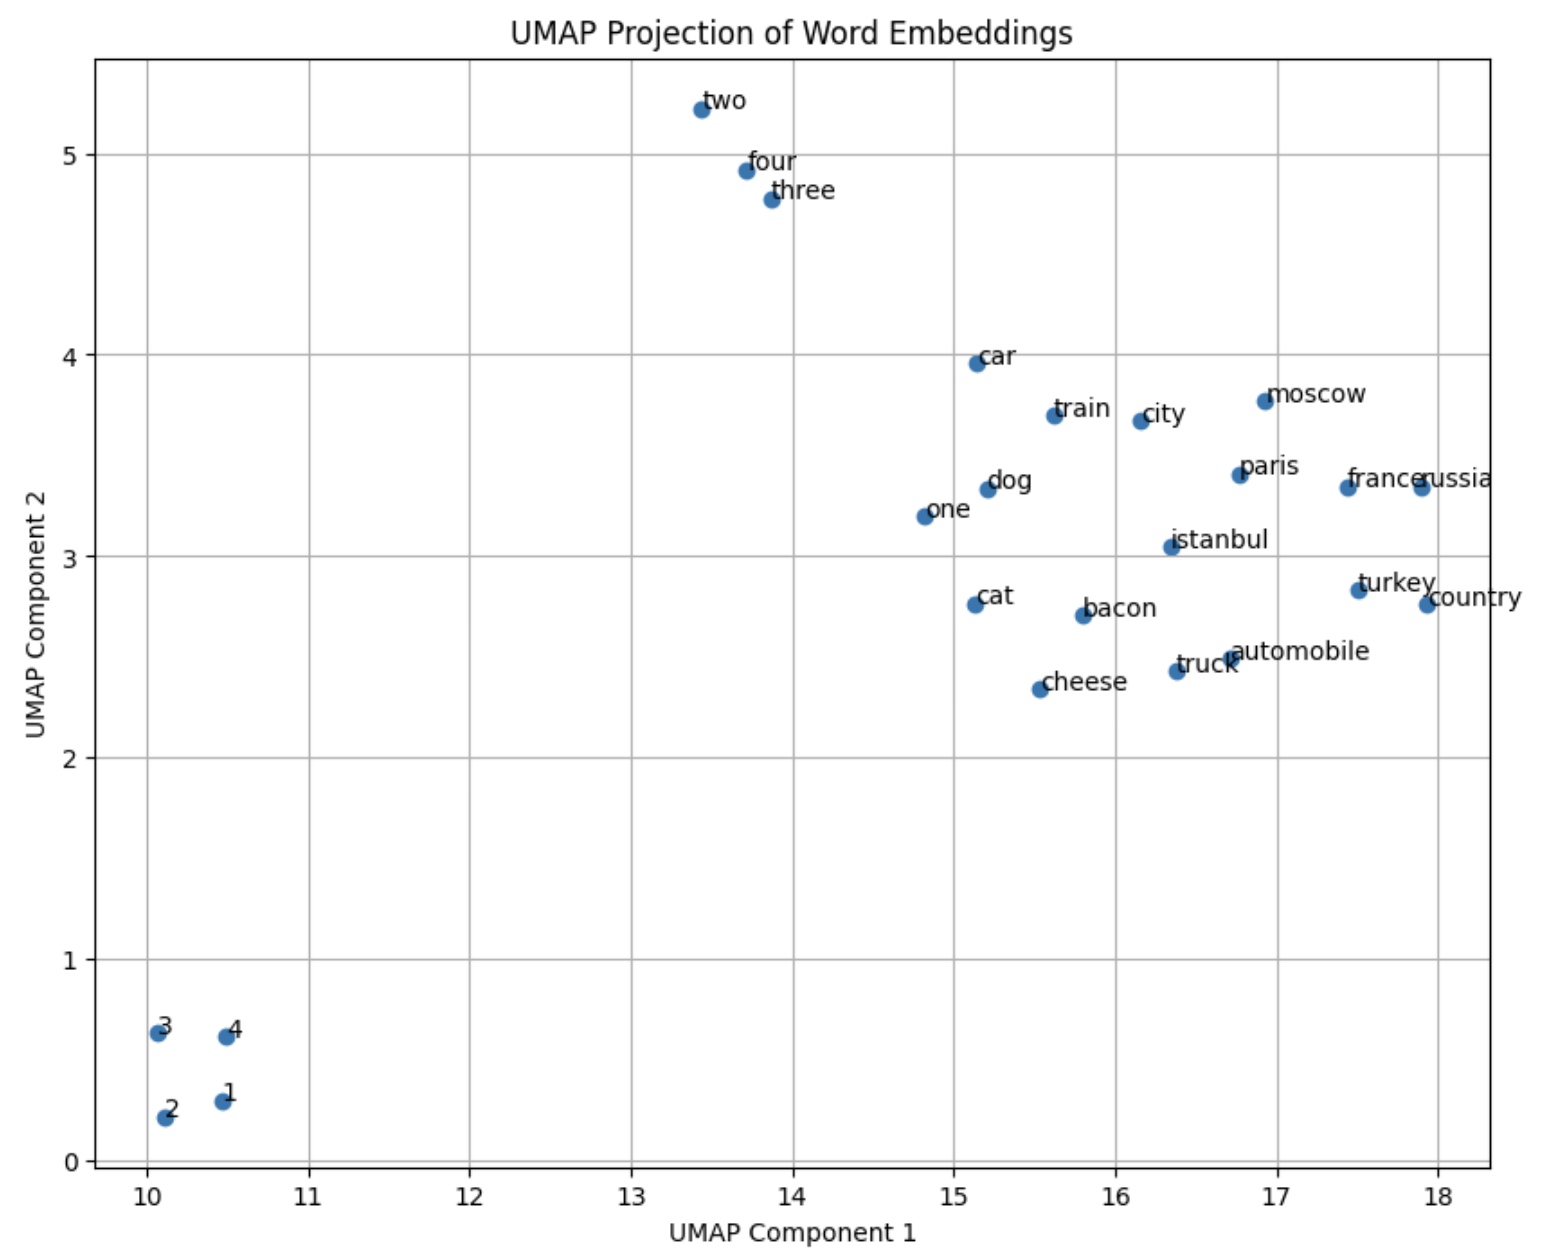


Your plot may look different.  However, semantically related words should be near each other in this two-dimensional representation.  You may also notice that the vectors for (france - paris) and (russia - moscow) are similar.

Word 'tofu' does not appear in collections.
Word 'hummus' does not appear in collections.


/Users/a.h./Documents/GitHub/NLP_proj/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


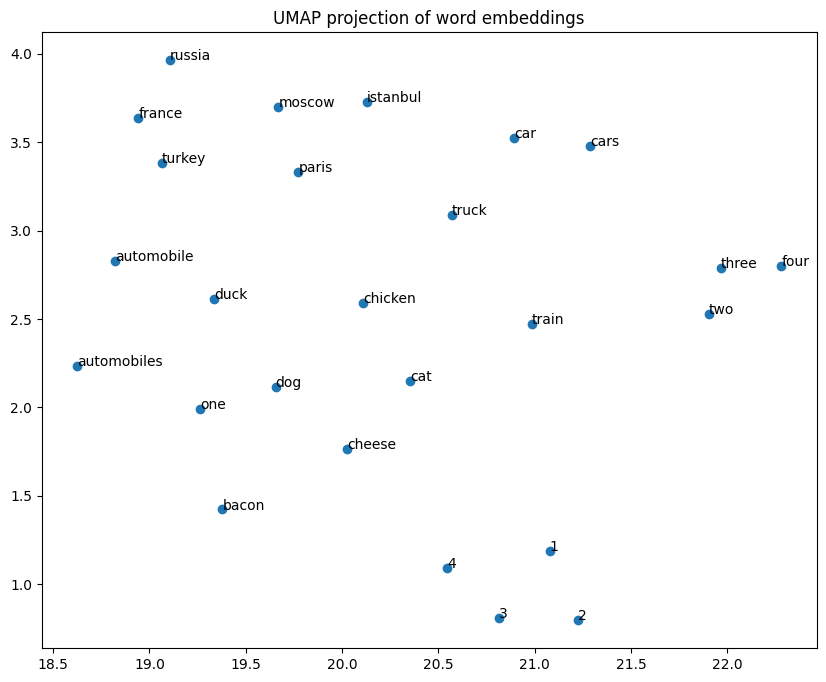

In [89]:
# Generate word embeddings
seed = 20
word_vectors = []
words_to_project = []

for w in words_to_visualize:
    try:
        word_vectors.append(model.wv[w])
        words_to_project.append(w)

    except Exception:
        print(f"Word '{w}' does not appear in collections.")
        continue

umap_model = umap.UMAP(random_state=seed)
word_embedding = umap_model.fit_transform(
    np.array(word_vectors)
)

# Plot umap
plt.figure(figsize=(10, 8))
plt.scatter(word_embedding[:, 0], word_embedding[:, 1])

# Label target words
for i, w in enumerate(words_to_project):
    plt.annotate(
        w, (word_embedding[i, 0], word_embedding[i, 1])
    )

plt.title("UMAP projection of word embeddings")
plt.show()

Better quality embeddings can be obtained from larger text. Let's load vectors built off of a much larger collection: the Google News pretrained embeddings. We will wipe out our original model to preserve memory. Note that this model is not case-normalized.

In [34]:
model = KeyedVectors.load_word2vec_format(
    "resources/GoogleNews-vectors-negative300.bin",
    binary=True,
)

We can verify that the model contains word vectors.

In [35]:
print(model["purple"])

[ 1.21093750e-01 -4.68750000e-02  3.58886719e-02  2.83203125e-01
 -1.66015625e-01 -8.05664062e-02  6.17675781e-02 -4.84375000e-01
 -9.47265625e-02 -4.88281250e-03 -1.34765625e-01  1.13281250e-01
  2.12890625e-01  9.91210938e-02 -1.34765625e-01 -2.25585938e-01
 -2.42187500e-01  1.56250000e-01 -6.98242188e-02 -2.18750000e-01
 -1.47460938e-01  2.98828125e-01 -1.01928711e-02 -2.21679688e-01
 -2.25585938e-01 -3.17382812e-02 -1.73828125e-01  4.68750000e-02
  2.50244141e-02 -2.21679688e-01 -4.39453125e-02  2.41210938e-01
  1.25976562e-01  1.62353516e-02 -1.08398438e-01  6.83593750e-02
  3.63281250e-01 -4.94384766e-03 -8.83789062e-02  2.22656250e-01
  7.32421875e-02 -8.34960938e-02 -4.71191406e-02 -2.69531250e-01
  1.26953125e-01 -8.30078125e-02  9.33837891e-03 -2.46093750e-01
 -7.56835938e-02  1.45507812e-01 -1.92382812e-01  1.26953125e-01
  1.85546875e-01 -3.05175781e-02  4.78515625e-02  4.73022461e-03
 -1.25000000e-01 -1.16210938e-01 -7.37304688e-02 -8.30078125e-02
 -1.94335938e-01  1.11816

Explore the gensim API. Note that sometimes Python complains about the presence of the `.wv` in the following invocations; other times it complains about its absence.

    model[x]: vector for word x
    model.wv.similarity(x, y): cosine similarity between vectors for x and y
    model.wv.distance(x, y): 1 - cosine similarity of x and y
    model.wv.most_similar(positive=[x, y, z], negative=[a, b, c], topn=k):  return k-most similar
    model.wv.most_similar_cosmul: like most_similar with a different function for three word analogies
To find the words most similar to wine:

    model.wv.most_similar (positive=['wine'])

**(2 points)** Use the API to find the words most similar to 'fascinating,' 'cultivate,' and 'eggplant,' and report your results. Is any of the most similar words a reasonable synonym or antonym for the input word?

**(2 points)** Do you believe that the similarity / distance functions are intuitive?  For example, are pairs like mother/father closer than mother/ocean? Explain your reasoning.

**(2 points)** According to the API, which words best complete the analogy, puppies is to dog as X is to cat?

**(2 points)** A classic example is queen = (king - man) + woman.  Find two other interesting analogies using the API.

**(5 points)** A pair of words might be synonyms, antonyms, similar, related, subordinate/superordinate, or unrelated. Identify at least one pair of words in each category, and compare their embeddings.  For example, you might compare plots, or compare cosines or L2 distances, etc. Given a pair of words, do you think it is possible to determine whether they are a) synonymous, b) antonymous, c) similar, d) related, e) subordinate/ superordinate, or f) unrelated, using only their embedding vectors? Give your reasoning for each category of relationship.

**(2 points)** Record any interesting observations, and report any examples you like of good or dubious performance.


In [37]:
# Extract words similar to 'fascinating', 'cultivate', 'eggplant'
target_words = ["fascinating", "cultivate", "eggplant"]
for w in target_words:
    similar_words = model.most_similar(
        positive=[w], topn=10
    )
    print(f"{w}: {[word for word, _ in similar_words]}")

fascinating: ['interesting', 'intriguing', 'enlightening', 'captivating', 'facinating', 'riveting', 'instructive', 'endlessly_fascinating', 'revelatory', 'engrossing']
cultivate: ['cultivating', 'cultivated', 'nurture', 'cultivates', 'develop', 'Cultivate', 'Cultivating', 'nuture', 'nourish', 'grow']
eggplant: ['zucchini', 'cauliflower', 'eggplants', 'bok_choy', 'bell_peppers', 'broccoli_rabe', 'bell_pepper', 'asparagus', 'pesto', 'escarole']


In [ ]:
# Find words that completes analogy
blank_words = model.most_similar(
    positive=["cat", "dog"], negative=["puppies"], topn=3
)
print(
    f"The word that most complete the analogy is: {blank_words}"
)

The word that most complete the analogy is: [('beagle', 0.6354864835739136), ('feline', 0.6032536029815674), ('pooch', 0.5945722460746765)]


In [43]:
# Find other analogies
analogies = [
    {"positive": ["woman", "king"], "negative": ["man"]},
    {"positive": ["bacon", "animal"], "negative": ["pig"]},
    {
        "positive": ["eggplant", "nurture"],
        "negative": ["grow"],
    },
]

for analogy in analogies:
    result = model.most_similar(
        positive=analogy["positive"],
        negative=analogy["negative"],
        topn=1,
    )
    print(
        f"{analogy['negative'][0]} is to {analogy['positive'][1]} as X is to {analogy['positive'][0]}: {result}"
    )

man is to king as X is to woman: [('queen', 0.7118193507194519)]
pig is to animal as X is to bacon: [('cooked_chicken_breasts', 0.4525792896747589)]
grow is to nurture as X is to eggplant: [('rapini', 0.5229064226150513)]


synonym - 'interesting' and 'intriguing': 0.8186
antonym - 'happy' and 'sad': 0.5355
similar - 'fascinating' and 'interesting': 0.7623
related - 'king' and 'queen': 0.6511
superordinate - 'vehicle' and 'car': 0.7821
subordinate - 'car' and 'bicycle': 0.5364
unrelated - 'bicycle' and 'zucchini': 0.1859


/Users/a.h./Documents/GitHub/NLP_proj/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/a.h./Documents/GitHub/NLP_proj/.venv/lib/python3.9/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


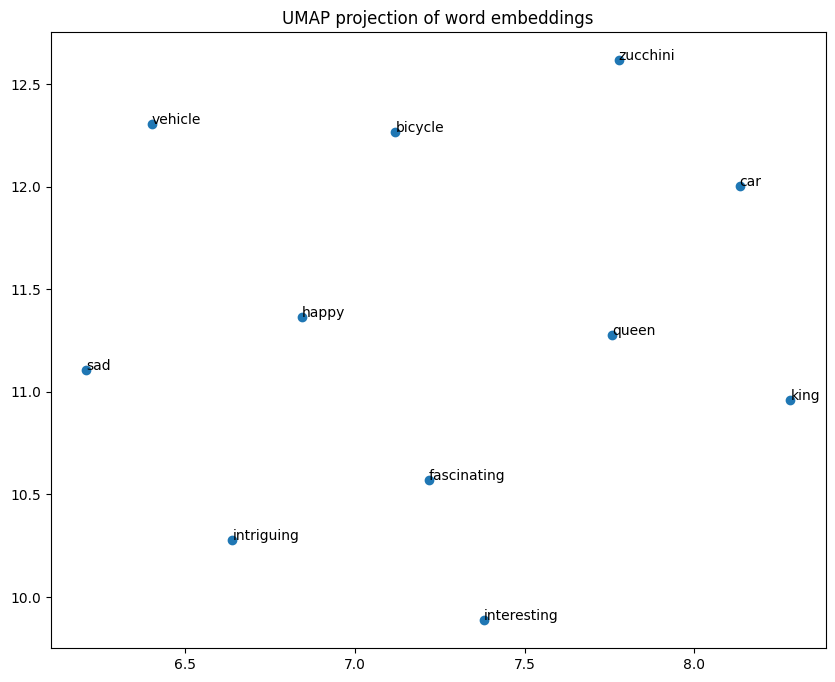

In [58]:
# Identify pairs of synonyms, antonyms, similar, related, subordinate/superordinate, unrelated words
categories = {
    "synonym": ["interesting", "intriguing"],
    "antonym": ["happy", "sad"],
    "similar": ["fascinating", "interesting"],
    "related": ["king", "queen"],
    "superordinate": ["vehicle", "car"],
    "subordinate": ["car", "bicycle"],
    "unrelated": ["bicycle", "zucchini"],
}

# Compute cosine similarity for each category
for category in categories.keys():
    w1, w2 = categories[category]
    similarity = model.similarity(w1, w2)
    print(
        f"{category} - '{w1}' and '{w2}': {similarity:.4f}"
    )

# UMAP projection of words
seed = 10
words = categories.values()
words_to_project = list(
    set([w for sublist in list(words) for w in sublist])
)
word_vectors = [model[w] for w in words_to_project]

umap_model = umap.UMAP(random_state=seed)
word_embedding = umap_model.fit_transform(
    np.array(word_vectors)
)

# Plot umap
plt.figure(figsize=(10, 8))
plt.scatter(word_embedding[:, 0], word_embedding[:, 1])

# Label target words
for i, w in enumerate(words_to_project):
    plt.annotate(
        w, (word_embedding[i, 0], word_embedding[i, 1])
    )

plt.title("UMAP projection of word embeddings")
plt.show()

In [61]:
analogy_on_unrelated_words = model.most_similar(
    positive=["zucchini", "car"],
    negative=["beagle"],
    topn=3,
)
print(
    f"Beagle is to car as X is to zucchini: {analogy_on_unrelated_words}"
)

Beagle is to car as X is to zucchini: [('cars', 0.5095071792602539), ('minivan', 0.4767092764377594), ('vehicle', 0.46843719482421875)]


## Part B: Exploring Contextual Word Embeddings

Now we will compare the static embeddings of Part A with contextual embeddings produced by SpaCy. The imports from Part A cover everything we need here.

SpaCy automatically builds a contextual embedding for each token it processes. Here is a function that returns a list of embedding vectors and the corresponding list of words for a given input sentence:

In [90]:
def tokenize(sentence, nlp):
    doc = nlp(sentence)
    return [token.vector for token in doc], [
        token.text for token in doc
    ]

We can use this function to recover the contextual embedding vector for a given word in a sentence:

In [91]:
def embed_word_contextual(word, sentence, nlp):
    embeddings, words = tokenize(sentence, nlp)
    return embeddings[words.index(word)]

This function just demonstrates how to find the right embedding. You will not want to call it repeatedly on the same sentence because it tokenizes every time it is called.

Here is a data structure that indicates a "word" and sets of sentences representing various senses of that word:

In [92]:
senses = {
    "word": "bank",
    "river": [
        "river bank",
        "I buried the money in the river bank",
        "I buried the money in the bank",
        "on the bank of the Ohio river",
        "on the bank of the Ohio",
        "I slid down the bank",
        "Silt deposits covered the bank",
        "I left my favorite pen on the bank",
        "Fortunately, no one was hurt sliding down the bank",
        "The bank was slippery and treacherous",
    ],
    "money": [
        "money bank",
        "The bank is a safe place to store your wealth",
        "The bank is a safe place to store your money",
        "The savings bank is a safe place to store your money",
        "I deposited the money in the bank",
        "The bank failure caused havoc in the financial markets",
        "I left my favorite pen at the bank",
        "The bank teller lives down by the river",
        "Fortunately, no one was hurt during the bank robbery",
        "The bank robber was slippery and treacherous",
    ],
}

**(5 points)** Again, use UMAP to create a two-dimensional plot of each of the instances of 'bank' in the above sentences together in a single diagram. Analyze the groupings you find in your plot. Do they make sense? Are the river and money senses of bank adequately separated? Can you identify the commonalities among the various instances of 'bank' in each cluster?

**(5 points)** Create your own example of a word that has two or more senses. Find ten sentences in ```small.txt``` containing your word for each of the senses you identify. Repeat your analysis on the examples you generated.

**(5 points)** For each of the words in the Part A plot, average the contextual embeddings for each occurrence of the word in ```small.txt```, then plot the results as you did in Part A. Compare this plot to your plot from Part A. Do the words congregate in the same way? What are the significant differences between the two plots? Can you identify an explanation for any significant differences?

/Users/a.h./Documents/GitHub/NLP_proj/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


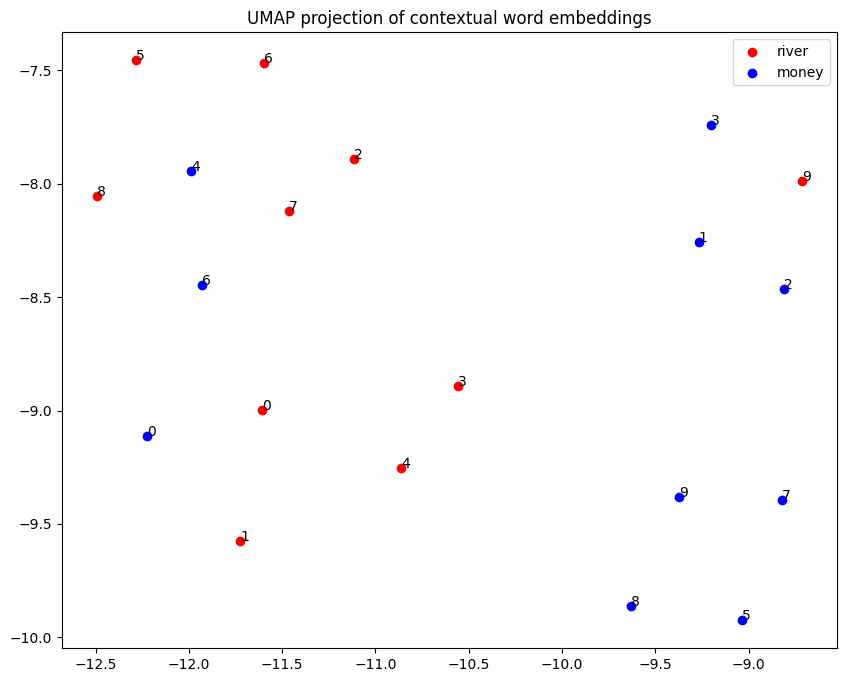

In [96]:
# UMAP of 'bank' in different contexts
seed = 10
word = senses["word"]
sentences = senses["river"] + senses["money"]

word_embeddings = [
    embed_word_contextual(word, sentence, nlp)
    for sentence in sentences
]
umap_model = umap.UMAP(random_state=seed)
embeddings_2D = umap_model.fit_transform(
    np.array(word_embeddings)
)

plt.figure(figsize=(10, 8))
plt.scatter(
    embeddings_2D[: len(senses["river"]), 0],
    embeddings_2D[: len(senses["river"]), 1],
    label="river",
    color="r",
)
for i, _ in enumerate(senses["river"]):
    plt.annotate(
        str(i), (embeddings_2D[i, 0], embeddings_2D[i, 1])
    )
plt.scatter(
    embeddings_2D[len(senses["river"]) :, 0],
    embeddings_2D[len(senses["river"]) :, 1],
    label="money",
    color="b",
)
for i, _ in enumerate(senses["money"]):
    plt.annotate(
        str(i),
        (
            embeddings_2D[len(senses["river"]) + i, 0],
            embeddings_2D[len(senses["river"]) + i, 1],
        ),
    )

plt.title(f"UMAP projection of contextual word embeddings")
plt.legend()
plt.show()

/Users/a.h./Documents/GitHub/NLP_proj/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/a.h./Documents/GitHub/NLP_proj/.venv/lib/python3.9/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


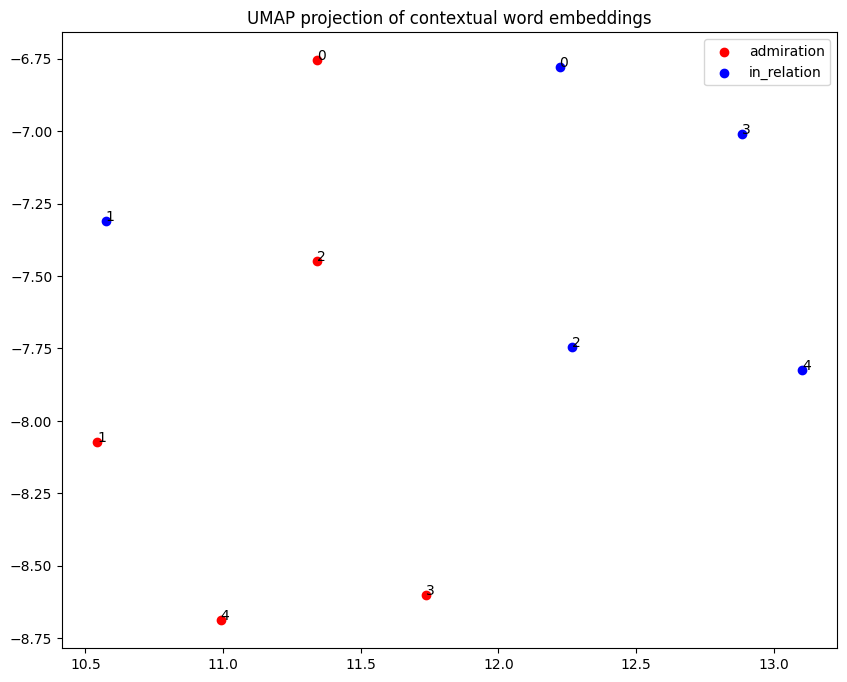

In [97]:
# Example word
senses = {
    "word": "respect",
    "admiration": [
        "The solutions must involve a re-emphasis of the values that have helped many blacks succeed: respect for the family, for the community, for one's self.",
        "They have sacrificed jobs and education, as well as the respect of family and friends who question their sanity.",
        "After the vote we will change the situation in the country and demand respect for ourselves and everyone and not only on the election day.",
        "The next generation is being challenged for their superiority of behavior and the induced sex education would surely overthrow the master culture of respect and regard.",
        "But when famous Ukrainian academicians I.Kuras, P.Tolochko, Y.Isayevich, I.Dzuba, M.Popovich and others speak on the Jewish issue they evoke a big respect and gratitude.",
    ],
    "in_relation": [
        "The similar situation with respect to the total mortality is observed in the cohort of Byelorussian and Ukrainian participants in the elimination of accident consequences.",
        "It recognised the promising progress made with this respect in the cooperation with the Ministerial Conference for the Protection of Forests and the European banks.",
        "TEPPFA shall not be bound by any confidentiality obligation with respect to the Materials.",
        "The law does not regulate the relations between the parties - lessees of one and the same land lot, with respect to its use included.",
        "'I have as yet made no decision with respect to the question of ICBM modernization,' Cheney said today.",
    ],
}

# UMAP of 'respect' in different contexts
seed = 10
word = senses["word"]
sentences = senses["admiration"] + senses["in_relation"]

word_embeddings = [
    embed_word_contextual(word, sentence, nlp)
    for sentence in sentences
]
umap_model = umap.UMAP(random_state=seed)
embeddings_2D = umap_model.fit_transform(
    np.array(word_embeddings)
)

plt.figure(figsize=(10, 8))
plt.scatter(
    embeddings_2D[: len(senses["admiration"]), 0],
    embeddings_2D[: len(senses["admiration"]), 1],
    label="admiration",
    color="r",
)
for i, _ in enumerate(senses["admiration"]):
    plt.annotate(
        str(i), (embeddings_2D[i, 0], embeddings_2D[i, 1])
    )
plt.scatter(
    embeddings_2D[len(senses["admiration"]) :, 0],
    embeddings_2D[len(senses["admiration"]) :, 1],
    label="in_relation",
    color="b",
)
for i, _ in enumerate(senses["in_relation"]):
    plt.annotate(
        str(i),
        (
            embeddings_2D[
                len(senses["in_relation"]) + i, 0
            ],
            embeddings_2D[
                len(senses["in_relation"]) + i, 1
            ],
        ),
    )

plt.title(f"UMAP projection of contextual word embeddings")
plt.legend()
plt.show()

Extracting sentences containing target words...
Extracting avg word embeddings...


100%|██████████| 28/28 [04:00<00:00,  8.57s/it]
/Users/a.h./Documents/GitHub/NLP_proj/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


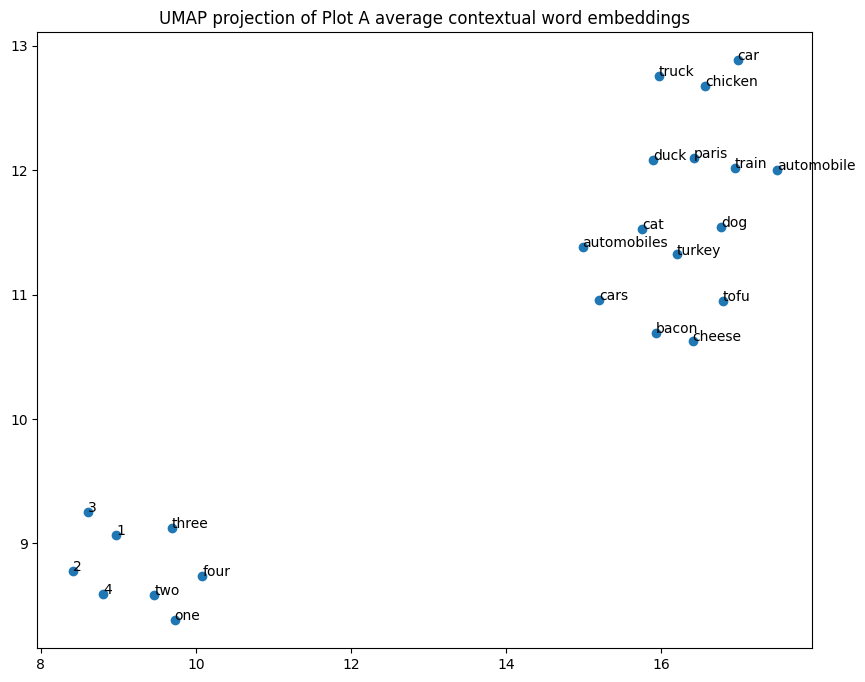

In [83]:
# Words to embed
words = [
    "paris",
    "istanbul",
    "moscow",
    "france",
    "turkey",
    "russia",
    "cat",
    "dog",
    "chicken",
    "duck",
    "truck",
    "train",
    "car",
    "cars",
    "automobile",
    "automobiles",
    "one",
    "two",
    "three",
    "four",
    "1",
    "2",
    "3",
    "4",
    "cheese",
    "bacon",
    "tofu",
    "hummus",
]

# Extract all sentences containing words
print("Extracting sentences containing target words...")
sentences = {}
for word in words:
    sentences[word] = []

with open("resources/small.txt", "r") as f:
    for line in f:
        for word in words:
            if word in line.lower():
                sentences[word].append(line)

# Calculate avg contextual embeddings for each word
print("Extracting avg word embeddings...")
word_embeddings = []
for word in tqdm(words):
    embeddings = []
    for s in sentences[word]:
        try:
            embeddings.append(
                embed_word_contextual(word, s, nlp)
            )
        except Exception:
            continue

    if len(embeddings) == 0:
        del sentences[word]

    else:
        avg_embedding = np.mean(embeddings, axis=0)
        word_embeddings.append(avg_embedding)

# Project embeddings with UMAP
seed = 20
umap_model = umap.UMAP(random_state=seed)
embeddings_2D = umap_model.fit_transform(
    np.array(word_embeddings)
)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2D[:, 0], embeddings_2D[:, 1])

# Annotate with word labels
for i, w in enumerate(sentences.keys()):
    plt.annotate(
        w, (embeddings_2D[i, 0], embeddings_2D[i, 1])
    )

plt.title(
    "UMAP projection of Plot A average contextual word embeddings"
)
plt.show()